In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def reset_timestamp(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def find_clumsy_directories(root='.'):
    res = []
    for dirpath, dirnames, filenames in os.walk(root):
        for dirname in dirnames:
            if 'clumsy' in dirname.lower() or 'validation' in dirname.lower():
                res.append(os.path.join(dirpath, dirname))
    return res

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = reset_timestamp(df)
    df = calculate_power(df)
    df.to_csv(f'.\\{data_path.strip(".log")}.csv', index=False)
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    if len(file_path.split('\\')[1].split('-')) == 3:
        altered_bandwidth = file_path.split('\\')[1].split('-')[1] == 'bandwidth'
        altered_dropchance = file_path.split('\\')[1].split('-')[1] == 'dropchance'
        bandwidth = int(file_path.split('\\')[1].split('-')[2][:-4]) if file_path.split('\\')[1].split('-')[1] == 'bandwidth' else 999999
        dropchance = float(file_path.split('\\')[1].split('-')[2]) if file_path.split('\\')[1].split('-')[1] == 'dropchance' else 0
    else:
        altered_bandwidth = True
        altered_dropchance = True
        bandwidth = 999999
        dropchance = 0
    device = file_path.split('\\')[2]
    app = file_path.split('\\')[3].strip('-W')
    app_details = file_path.split('\\')[4]
    is_record = 'record' in file_path.split('\\')[5]
    is_wireless = '-W' in file_path.split('\\')[3]
    repetition = file_path.split('\\')[5].strip('record') if 'record' in file_path.split('\\')[5] else file_path.split('\\')[5].strip('replay')
    
#     print(df)
    return [altered_bandwidth, altered_dropchance, bandwidth, dropchance, device, app, app_details, is_record, is_wireless, repetition]


clumsy_dirs = find_clumsy_directories()

df_aggregated = []  # List to store dictionaries for each row

for clumsy in clumsy_dirs:
    for root, dirs, files in os.walk(clumsy, topdown=False):
        for name in files:
            if name == 'battery_manager.log':
                if os.path.join(root, name) == '.\\clumsy-dropchance-0.05\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.2\\battery_manager.log':
                    continue
                try:
                    print(os.path.join(root, name))
                    energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                    row_data = create_dataframe(os.path.join(root, name)) + [energy, length, float(energy / length)]
                    # Append a dictionary for each row
                    df_aggregated.append(dict(zip(['altered_bandwidth', 'altered_dropchance', 'bandwidth', 'dropchance', 'device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)', 'Energy per Second (J/s)'], row_data)))
                except:
                    print(f'{os.path.join(root, name)} not functional')

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(df_aggregated)
df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log


,altered_bandwidth,altered_dropchance,bandwidth,dropchance,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,True,False,1,1617.171011,257.057,6.291099
1,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,False,False,1.0,1581.767128,265.926,5.948148
2,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,False,False,1.1,1574.781731,265.785,5.925021
3,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,False,False,1.2,1569.581838,264.700,5.929663
4,True,False,100,0.0,Quest-Pro,BeatSaber,PopStars-Medium,True,False,1,2132.318163,283.780,7.513983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.5,1636.892353,277.125,5.906693
131,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.6,1605.473918,272.993,5.881008
132,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.7,1612.792951,273.933,5.887545
133,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.8,1611.205237,274.862,5.861870


In [3]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                 "xtick.bottom": True,
                 "ytick.left": True,
                 "axes.edgecolor": "black",
                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray"}

# sns.set_theme(style="whitegrid", rc=custom_params)
# sns.set_palette("deep")
# sns.set(font_scale=1.7)

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}


C:\Users\radua\AppData\Local\Temp\ipykernel_6232\3346432648.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y='device', x='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='deep')


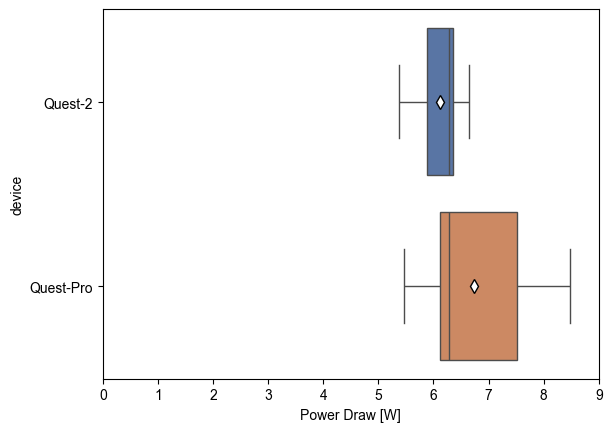

In [4]:
# print(df.empty())
# pd.set_option('Energy per Second (J/s).max_rows', None)

# Print the entire 'device' column
# print(df['Energy per Second (J/s)'])
# print(df.dropna())
# df['device'] = df['device'].astype(str)
sns.boxplot(data=df, y='device', x='Energy per Second (J/s)', showmeans=True, meanprops=custom_mean, palette='deep')
plt.xlim(0, 9)
plt.xlabel('Power Draw [W]')
plt.show()

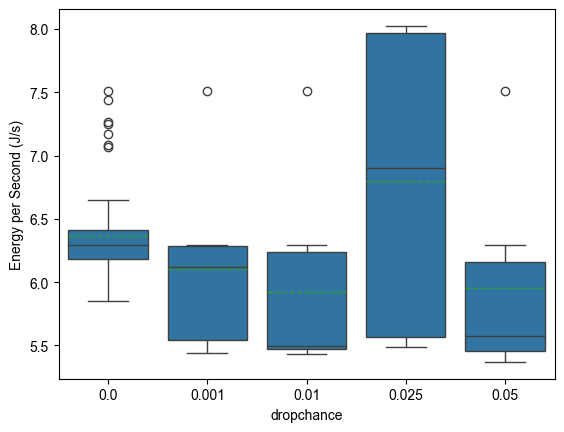

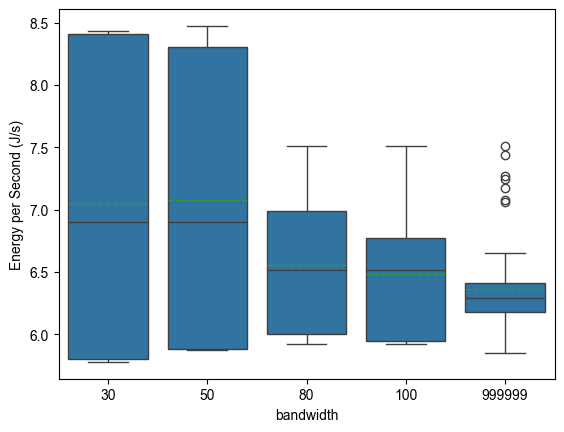

In [5]:
sns.boxplot(data=df[(df.altered_dropchance == True)], x='dropchance', y='Energy per Second (J/s)', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df[(df.altered_bandwidth == True)], x='bandwidth', y='Energy per Second (J/s)', showmeans=True, meanline=True)
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_6232\486904487.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="deep", ax=ax)
C:\Users\radua\AppData\Local\Temp\ipykernel_6232\486904487.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


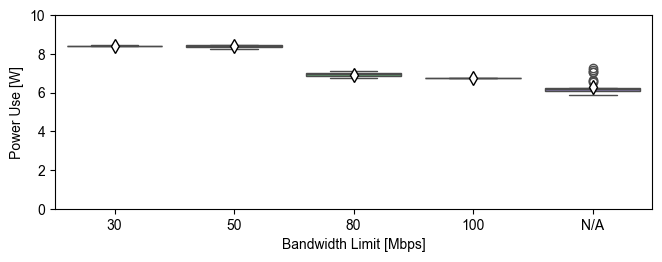

In [6]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.6)

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="deep", ax=ax)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[4] = 'N/A'
ax.set_xticklabels(labels)
ax.set_ylim(0, 9)
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_xlabel('Bandwidth Limit [Mbps]')
ax.set_ylabel('Power Use [W]')

plt.tight_layout()
# plt.savefig('./figures/first_pager_bandwidth.pdf', bbox_inches='tight', format='pdf')
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_6232\1197151426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: 'N/A' if x == 999999 else str(x))
C:\Users\radua\AppData\Local\Temp\ipykernel_6232\1197151426.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.sort_values('bandwidth', ascending=False, inplace=True)
C:\Users\radua\AppData\Local\Temp\ipykernel_6232\1197151426.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` var

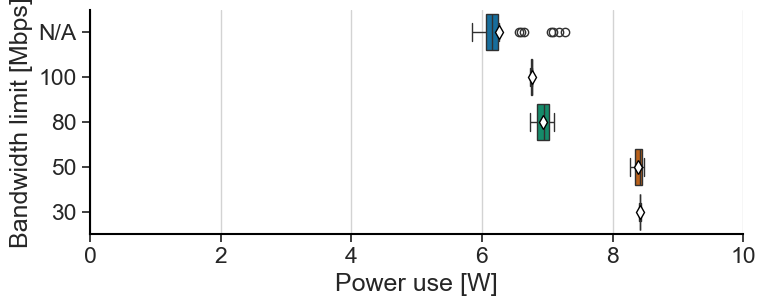

In [13]:
fig, ax = plt.subplots(figsize=(8, 3.4))
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]
to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: 'N/A' if x == 999999 else str(x))
to_plot.sort_values('bandwidth', ascending=False, inplace=True)

sns.boxplot(x=to_plot['Energy per Second (J/s)'], y=to_plot['bw_text'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax)

ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_ylabel('Bandwidth limit [Mbps]')
ax.set_xlabel('Power use [W]')

plt.tight_layout()
plt.savefig('./figures/first_pager_bandwidth.pdf', bbox_inches='tight', format='pdf')
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_6232\1369483670.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[0])
C:\Users\radua\AppData\Local\Temp\ipykernel_6232\1369483670.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels)
C:\Users\radua\AppData\Local\Temp\ipykernel_6232\1369483670.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="deep"

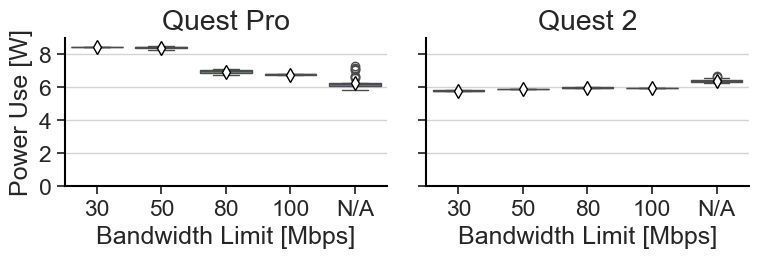

In [8]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=2, sharey=True)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[0])

labels = [item.get_text() for item in axes[0].get_xticklabels()]
labels[4] = 'N/A'
axes[0].set_xticklabels(labels)
axes[0].set_ylim(0, 9)
axes[0].set_yticks([0, 2, 4, 6, 8])
axes[0].set_xlabel('Bandwidth Limit [Mbps]')
axes[0].set_ylabel('Power Use [W]')
axes[0].set_title('Quest Pro')


to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-2')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[1])

labels = [item.get_text() for item in axes[1].get_xticklabels()]
labels[4] = 'N/A'
axes[1].set_xticklabels(labels)
axes[1].set_ylim(0, 9)
axes[1].set_yticks([0, 2, 4, 6, 8])
axes[1].set_xlabel('Bandwidth Limit [Mbps]')
axes[1].set_ylabel('Power Use [W]')
axes[1].set_title('Quest 2')

plt.tight_layout()
plt.savefig('./figures/energy/watts_vs_bandwidth.pdf', dpi=300, format='pdf')
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_6232\3295898750.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[0])


C:\Users\radua\AppData\Local\Temp\ipykernel_6232\3295898750.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels)
C:\Users\radua\AppData\Local\Temp\ipykernel_6232\3295898750.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[1])
C:\Users\radua\AppData\Local\Temp\ipykernel_6232\3295898750.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels)


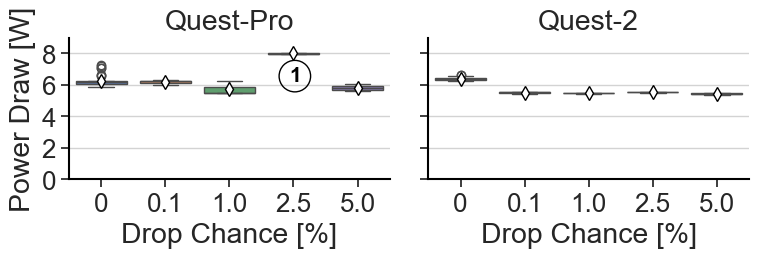

In [9]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=2, sharey=True)

to_plot = df[(df['altered_dropchance'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[0])
axes[0].annotate('1', (2.93, 6.2), 
                 bbox={"boxstyle" : "circle", "facecolor" : "none", "edgecolor" : "black"}, 
                 color='black', fontweight='bold', fontsize=15)

labels = [float(item.get_text()) for item in axes[0].get_xticklabels()]
labels = [str(x*100) for x in labels]
labels[0] = '0'
axes[0].set_xticklabels(labels)
axes[0].set_ylim(0, 9)
axes[0].set_yticks([0, 2, 4, 6, 8])
axes[0].set_xlabel('Drop Chance [%]')
axes[0].set_ylabel('Power Draw [W]')
axes[0].set_title('Quest-Pro')

to_plot = df[(df['altered_dropchance'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-2')]

sns.boxplot(y=to_plot['Energy per Second (J/s)'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[1])

labels = [float(item.get_text()) for item in axes[1].get_xticklabels()]
labels = [str(x*100) for x in labels]
labels[0] = '0'
axes[1].set_xticklabels(labels)
axes[1].set_ylim(0, 9)
axes[1].set_xlabel('Drop Chance [%]')
axes[1].set_ylabel('Power Draw [W]')
axes[1].set_title('Quest-2')

plt.tight_layout()
plt.savefig('./figures/energy/watts_vs_dropchance.pdf', dpi=300, format='pdf')
plt.show()